In [1]:
import torch
from matplotlib import pyplot as plt
import yaml

from models.autoencoder import Autoencoder
from data.era5 import ERA5Dataset, gen_bgen

In [2]:
with open("configs/autoencoder_kl_f8.yaml", "r") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

device = "cpu"

model = Autoencoder.load_from_checkpoint(
    "checkpoints/vae-kl-f8-1440x720-69c-step=23400.ckpt").to(device)

model.eval()

bgen = gen_bgen(train=False)
dataset = ERA5Dataset(bgen)

sample = dataset[100].unsqueeze(0)

In [3]:
with torch.no_grad():
    sample = sample.to(model.device)

    rec, posterior = model.forward(sample)

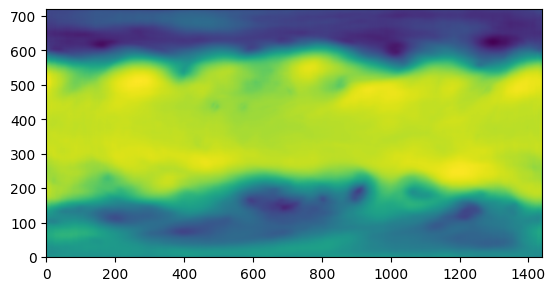

In [4]:
geo = rec.cpu().squeeze().numpy()

plt.imshow(geo[52].T, origin="lower")

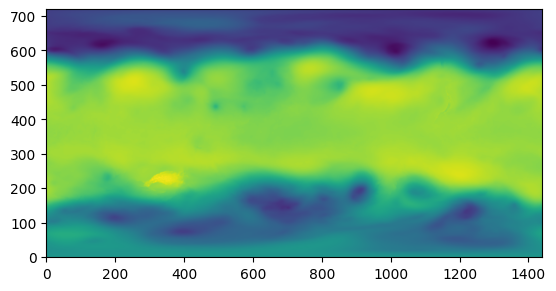

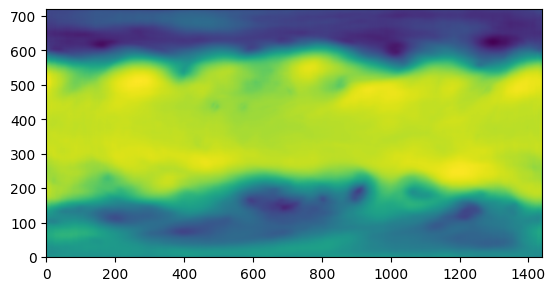

In [5]:
geo_sample = sample.cpu().squeeze().numpy()[52]
geo_rec = rec.cpu().squeeze().numpy()[52]

plt.figure()
plt.imshow(geo_sample.T, origin="lower")
plt.figure()
plt.imshow(geo_rec.T, origin="lower")

plt.show()

In [6]:
geo_mean = 28868.4465
geo_std = 1919.40426

geo_sample_denorm = (geo_sample * geo_std) + geo_mean
geo_rec_denorm = (geo_rec * geo_std) + geo_mean

In [7]:
# rmse of geo_sample_denorm and geo_rec_denorm

import numpy as np

rmse = np.sqrt(np.mean(((geo_sample_denorm - geo_rec_denorm) ** 2)))
print(rmse)

169.99796
